# Data
I used a modified version of the data from David Byler's RealClearPolitics model. Byler explains how he constructed his dataset [here](http://www.realclearpolitics.com/articles/2015/08/26/rcp_demographic_interactive_map_methodology__127889.html), and I will give a brief summary below:

Byler's main data sources were:
* The [United States Election Project](http://www.electproject.org/home/voter-turnout/voter-turnout-data) (to get national voting eligible population and turnout data)
* [AEI States of Change](https://www.aei.org/feature/states-change-demographics-democracy/) (to break the VEP into demographic groups)
* Roper Center exit polls from the [2008](http://ropercenter.cornell.edu/polls/us-elections/how-groups-voted/how-groups-voted-2008/) and [2012](http://ropercenter.cornell.edu/polls/us-elections/how-groups-voted/how-groups-voted-2012/) presidential elections (to get demographic turnout and vote share data by demographic group)
* [Fox News exit polls](http://www.foxnews.com/politics/elections/2014/exit-polls) (to get demographic turnout and vote share data by demographic group and state)

Byler first obtained a projection of the 2016 voting eligible population by taking data from the last few elections from the United States Election Project and applying a simple average growth rate to the 2012 number. He then broke the 2016 electorate into demographic groups using the AEI States of Change data. Finally, he found demographic vote-share and turnout by state using exit polls. For the 30 states that had available exit polls in 2012, Byler took these at face value. For the remaining 21, he found reasonable "defaults," in a process which he details on the page linked above. Finally, he adjusted the vote-share numbers slightly to make sure that state and national results closely match the actual results of 2012 when using 2012 VEP data.

Below, I will do some sanity checks on my dataset, which is essentially Byler's with some added historical data that he omitted, all from the same sources above.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import json

%matplotlib inline
from IPython.display import display

#nice defaults for matplotlib
from matplotlib import rcParams

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

In [2]:
with open('state_data.json', 'r') as infile:
    data = json.load(infile)

First, I verify Byler's projection of the 2016 VEP, using data from the United States Election Project.

In [3]:
# Byler's projection
vep_2016 = sum(data['USA']['2016']['VEP'].values())

# US Election Project data
us_election_proj = pd.read_excel('verification/1980-2014 November General Election.xlsx')
vep_data = us_election_proj[(us_election_proj['State'] == 'United States') & (us_election_proj['Year'] >= 2000)][['Year', 'Voting-Eligible Population (VEP)']].sort_values('Year', ascending=True)
vep_data.columns = ['Year', 'VEP']
vep_data

,Year,VEP
364,2000,194331436
312,2002,198381939
260,2004,203483455
208,2006,207643594
156,2008,213313508
104,2010,217551109
52,2012,222474111
0,2014,227157964


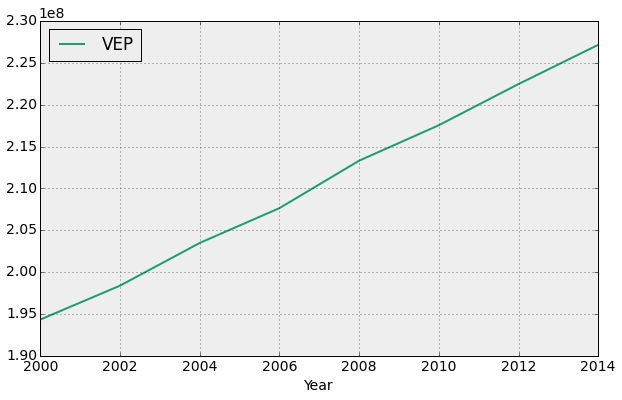

In [4]:
vep_data.plot(x='Year', y='VEP')
plt.show()

In [5]:
slope, intercept, r_value, p_value, std_err = stats.linregress(vep_data['Year'], vep_data['VEP'])
predict = intercept + slope * 2016
err = (predict - vep_2016) / predict
print 'Error is: {}%'.format(round(err * 100, 2))

Error is: 2.09%


We find that a simple linear regression estimates the VEP at 2% higher than Byler's estimate. While this is a bit high, it is tolerable, and likely due to the fact that Byler adjusts the VEP to make other (perhaps more important) numbers work. Therefore, it is plausible that Byler's adjusted estimate is actually more reliable than a simple linear regression prediction.

In order to sanity-check the data, let's compare its predictions for the 2012 election to the actual results. Since the data is simply 2012 turnout and voteshare and 2016 VEP, we will just replace the 2016 VEP with the known 2012 VEP, and multiply out to get vote-share per-state, and compare this to the real results (obtained from [archive.org](https://www.archives.gov/federal-register/electoral-college/2012/popular-vote.html)). Note that there are slight adjustments to re-weight totals, since our model ignores third-party candidates.

In [6]:
results_2012 = pd.read_excel('verification/2012_results.xlsx')

In [7]:
results_2012.head()

,State,Democratic Party,Republican Party,Libertarian Party,Green Party,Others,Total Votes
0,AL,795696,1255925,12328,3397,6992,2074338
1,AK,122640,164676,7392,2917,-,297625
2,AZ,1025232,1233654,32100,7816,452,2299254
3,AR,394409,647744,16276,9305,1734,1069468
4,CA,7854285,4839958,143221,85638,115455,13038547


In [8]:
# reweight to ignore 3rd party votes
results_2012['dem_pct'] = results_2012['Democratic Party'] / (results_2012['Democratic Party'] + results_2012['Republican Party'])

In [9]:
state_results_2012 = {}
for state_name in data:
    state = data[state_name]
    dem_votes = 0
    total_voters = 0
    for group in state['2016']['dem_pct']:
        voters = state['2016']['turnout'][group] * state['2016']['VEP'][group]
        total_voters += voters
        dem_votes += state['2012']['dem_pct'][group] * voters
    state_results_2012[state_name] = float(dem_votes) / total_voters

In [10]:
prediction_2012 = pd.DataFrame([{'State': k, '2012 Prediction': v} for k, v in state_results_2012.items()]).set_index('State')
prediction_results = pd.merge(prediction_2012, results_2012.set_index('State'), left_index=True, right_index=True)
prediction_errors = prediction_results['dem_pct'] - prediction_results['2012 Prediction']
prediction_errors.describe()

count    50.000000
mean     -0.006136
std       0.016152
min      -0.082734
25%      -0.012193
50%      -0.003710
75%       0.003467
max       0.015768
dtype: float64

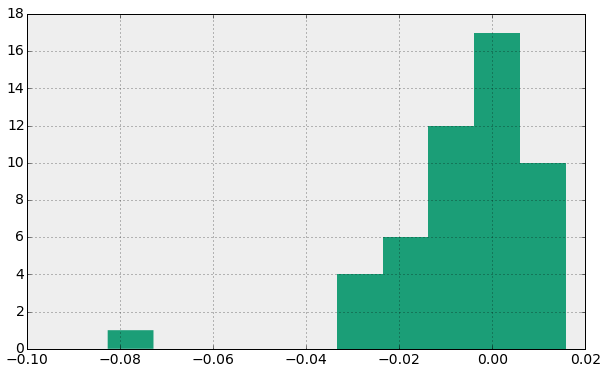

In [21]:
prediction_errors.hist()
plt.show()

We can see that Byler's data on average underestimates the Democratic vote share by just .6 percentage points, and its maximum error is just 1.5 percentage points, ignoring Utah, which is a large outlier (this is likely due to the fact that Mitt Romney is a Mormon and Utah is a highly Mormon state. As Byler notes, Romney had something of a home state advantage there, so 2012 results are not particularly representative of the state's general political climate).